In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')
%matplotlib notebook

In [62]:
xmax = 20 #max x values in m
ymax = 20 #max y values in m
zmax = 20 #max z values in m
h = 1 #amount of space each point represents in m**3

In [63]:
space = np.zeros((xmax, ymax, zmax))

In [64]:
dv = 1
dr = (dv)**(1/3)

# Wind

In [65]:
def sun_e(space, eavg=1.08e7, estd=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *eavg*
            int average value of energy from sun in J/m**2/day;
            default = 1.08e7 (average over Chicago)
        *estd*
            int standard deviation of energy from sun from eavg;
            default = 1
    :Returns:
        *energies*
            numpy.array values of energy from sun in J/m**2/day using
            edist with mean eavg
    '''
    energies = np.zeros(space.shape)
    for i in range(np.array(space.shape)[0]):
        for j in range(np.array(space.shape)[1]):
            e = np.random.normal(loc=eavg, scale=estd)
            energies[i, j, -1] = e

    return energies

# Cloud

In [66]:
def cloud(space, loc=(10,10,10), size=(10,1,1), hcloud=1, hmed=.95, hair=.69):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            tuple location of center of cloud;
            default = (10,10,10)
        *size*
            tuple size of cloud;
            default = (10,1,1)
        *hcloud*
            int humidity of cloud;
            default = 1
        *hair*
            int humidity of air;
            default = 0
    :Returns:
        *humidities*
            numpy.array values of humidity
    '''
    assert all([i >= 0 for i in np.array(loc)-np.array(size)/2]) and \
    all([i >= 0 for i in np.array(space.shape)-np.array(loc)+np.array(size)/2]), \
    'Cloud must be within space.'

    humidities = space

    humidities[:][:][:] = hair

    n = np.array(size) % 2

    i = np.array(loc)[0]
    j = np.array(loc)[1]
    k = np.array(loc)[2]

    a0 = int(i-np.array(size)[0]/2)
    a1 = int(i+np.array(size)[0]/2) + n[0]
    b0 = int(j-np.array(size)[1]/2)
    b1 = int(j+np.array(size)[1]/2) + n[1]
    c0 = int(k-np.array(size)[2]/2)
    c1 = int(k+np.array(size)[2]/2) + n[2]

    humidities[a0-1:a1+1, b0-1:b1+1, c0-1:c1+1] = hmed
    humidities[a0:a1, b0:b1, c0:c1] = hcloud

    return humidities

# Tornado

In [67]:
def tornado(space, loc=10, lpress=10, rpress=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            int location of pressure difference;
            default = 10

    :Returns:
        *pressures*
            numpy.array values of pressure
    '''
    assert 0 < loc and loc < np.array(space.shape)[0], 'Pressure difference must be within space.'

    pressures = altitude_pressures(space)

    pressures[loc:, :, :] *= rpress

    pressures[:loc, :, :] *= lpress

    return pressures

# Algorithm: Wind

In [68]:
def energytopressure(energies, dV):
    ps = energies/dV
    return ps

In [69]:
def altitude_pressures(space):
    pressures = space
    for h in range(np.array(space.shape)[2]):
        p = 101325*np.e**(-0.000119806*h)
        pressures[:, :, h] = p
    return pressures

In [152]:
def calc_J_air(pressures, dV=dv, D=1.76e-5, T=329):
    R = 8.314598
    js = np.zeros([np.array(pressures.shape)[0], np.array(pressures.shape)[1], np.array(pressures.shape)[2], 9])
    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                p = pressures[i, j, k]

                n = p*dV/(R*T)
                phi = n/dV

                try:
                    assert i-1 != -1
                    pleft = pressures[i-1, j, k]
                    n = pleft*dV/(R*T)
                    phileft = n/dV
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    pright = pressures[i+1, j, k]
                    n = pright*dv/(R*T)
                    phiright = n/dv
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    pfront = pressures[i, j-1, k]
                    n = pfront*dV/(R*T)
                    phifront = n/dV
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    pback = pressures[i, j+1, k]
                    n = pback*dV/(R*T)
                    phiback = n/dV
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    pdown = pressures[i, j, k-1]
                    n = pdown*dV/(R*T)
                    phidown = n/dV
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    pup = pressures[i, j, k+1]
                    n = pup*dV/(R*T)
                    phiup = n/dV
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                    gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = -D*gradphi
                js[i, j, k, :] = J
    return js

In [229]:
pressures = altitude_pressures(space)
R = 8.314598
js = np.zeros([np.array(pressures.shape)[0], np.array(pressures.shape)[1], np.array(pressures.shape)[2], 9])
for i in range(np.array(pressures.shape)[0]):
    for j in range(np.array(pressures.shape)[1]):
        for k in range(np.array(pressures.shape)[2]):
            p = pressures[i, j, k]

            n = p*dV/(R*T)
            phi = n/dV

            try:
                assert i-1 != -1
                pleft = pressures[i-1, j, k]
                n = pleft*dV/(R*T)
                phileft = n/dV
                dphileft = phi - phileft
            except:
                phileft = np.nan
                dphileft = np.zeros(np.array(pressures.shape)[:2])

            try:
                pright = pressures[i+1, j, k]
                n = pright*dv/(R*T)
                phiright = n/dv
                dphiright = phi - phiright
            except:
                phiright = np.nan
                dphiright = np.zeros(np.array(pressures.shape)[:2])

            try:
                assert j-1 != -1
                pfront = pressures[i, j-1, k]
                n = pfront*dV/(R*T)
                phifront = n/dV
                dphifront = phi - phifront
            except:
                phifront = np.nan
                dphifront = np.zeros(np.array(pressures.shape)[:2])

            try:
                pback = pressures[i, j+1, k]
                n = pback*dV/(R*T)
                phiback = n/dV
                dphiback = phi - phiback
            except:
                phiback = np.nan
                dphiback = np.zeros(np.array(pressures.shape)[:2])

            try:
                assert k-1 != -1
                pdown = pressures[i, j, k-1]
                n = pdown*dV/(R*T)
                phidown = n/dV
                dphidown = phi - phidown
            except:
                phidown = np.nan
                dphidown = np.zeros(np.array(pressures.shape)[:2])

            try:
                pup = pressures[i, j, k+1]
                n = pup*dV/(R*T)
                phiup = n/dV
                dphiup = phi - phiup
            except:
                phiup = np.nan
                dphiup = np.zeros(np.array(pressures.shape)[:2])

            gradphix = (dphileft - dphiright)/2 #phiright-phileft
            gradphiy = (dphiback - dphifront)/2 #phifront-phiback
            gradphiz = (dphidown - dphiup)/2 #phiup-phidown

            gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                gradphix, gradphiy, gradphix])/(dV)**(1/3)
            J = -D*gradphi
            js[i, j, k, :] = J

C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in subtract
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in subtract
C:\Users\bourg\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: 

In [233]:
J.shape

(9, 20, 20)

In [231]:
js[]

array([[[[[[ -0.,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ -0.,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ -0.,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           ..., 
           [ -0.,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ -0.,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ -0.,  -0.,  -0., ...,  -0.,  -0.,  -0.]],

          [[ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           ..., 
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.]],

          [[ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           ..., 
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0., ...,  -0.,  -0.,  -0.],
           [ nan,  -0.,  -0

In [197]:
def pressure_diffusion(pressures, dV=dv, T=329, dt=1):
    js = calc_J_air(pressures)
    R = 8.314598
    Rarray = R*np.ones(pressures.shape)
    ns = np.divide(pressures*dV, Rarray*T)

    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                a = -js[i, j, k, 0]/2*np.random.normal(loc=1, scale=.2)
                b = -js[i, j, k, 1]/2*np.random.normal(loc=1, scale=.2)
                c = -js[i, j, k, 2]/2*np.random.normal(loc=1, scale=.2)
                d = -js[i, j, k, 3]/2*np.random.normal(loc=1, scale=.2)
                e = -js[i, j, k, 4]/2*np.random.normal(loc=1, scale=.2)
                f = -js[i, j, k, 5]/2*np.random.normal(loc=1, scale=.2)

                if a > 0:
                    ns[i, j, k] += a
                    ns[i-1, j, k] -= a
                if b > 0:
                    ns[i, j, k] += b
                    ns[i+1, j, k] -= b

                if c > 0:
                    ns[i, j, k] += c
                    ns[i, j+1, k] -= c
                if d > 0:
                    ns[i, j, k] += d
                    ns[i, j-1, k] -= d

                if e > 0:
                    ns[i, j, k] += e
                    ns[i, j, k-1] -= e
                if f > 0:
                    ns[i, j, k] += f
                    ns[i, j, k+1] -= f

    pressures = ns*R*T/dV
    return pressures

In [209]:
def integrate_from_sun(space, dV=dv, tmax=20,
                       dt=1):
    pressures = np.zeros(space.shape)
    times = np.arange(0, tmax+1, dt)
    pt = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    ps = altitude_pressures(space)
    for t in times:
        pt[t] = ps
        energies = sun_e(space)
        ps += energytopressure(energies, dV)
        print(sum(ps))
        ps = pressure_diffusion(ps, dt)
    return pt

In [210]:
pt = integrate_from_sun(space)

[[  2.02650000e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237682e+06   2.02213455e+06   2.18021896e+08]
 [  2.02650000e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237682e+06   2.02213455e+06   2.18021894e+08]
 [  2.02650000e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650000e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237684e+06   2.01633343e+06   6.50027706e+08]
 [  2.02650000e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237684e+06   2.01633794e+06   6.50027693e+08]
 [  2.02650000e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650001e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237699e+06   2.00374754e+06   1.08204028e+09]
 [  2.02650001e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237699e+06   2.00239028e+06   1.08204164e+09]
 [  2.02650001e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650001e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237738e+06   1.98302694e+06   1.51406100e+09]
 [  2.02650001e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237741e+06   1.98177415e+06   1.51406226e+09]
 [  2.02650001e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407358e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650002e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237881e+06   1.93709587e+06   2.16210694e+09]
 [  2.02650002e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02237882e+06   1.93598776e+06   2.16210805e+09]
 [  2.02650002e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407358e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650002e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02238046e+06   1.89694194e+06   2.59414709e+09]
 [  2.02650002e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02238045e+06   1.89424408e+06   2.59414978e+09]
 [  2.02650002e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455863e+06   2.02431610e+06   2.02407358e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650003e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407358e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02238272e+06   1.84821804e+06   3.02619581e+09]
 [  2.02650003e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02238296e+06   1.84737736e+06   3.02619664e+09]
 [  2.02650003e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407358e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650003e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455863e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02238795e+06   1.76567335e+06   3.67427835e+09]
 [  2.02650003e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02238856e+06   1.76097190e+06   3.67428304e+09]
 [  2.02650003e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650004e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480121e+06
    2.02455863e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02239279e+06   1.69572337e+06   4.10634830e+09]
 [  2.02650004e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552909e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02239337e+06   1.69481875e+06   4.10634920e+09]
 [  2.02650004e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

[[  2.02650004e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480121e+06
    2.02455863e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02239864e+06   1.61862604e+06   4.53842538e+09]
 [  2.02650004e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06   2.02239967e+06   1.62243040e+06   4.53842157e+09]
 [  2.02650004e+06   2.02625723e+06   2.02601448e+06   2.02577177e+06
    2.02552908e+06   2.02528643e+06   2.02504380e+06   2.02480120e+06
    2.02455864e+06   2.02431610e+06   2.02407359e+06   2.02383110e+06
    2.02358865e+06   2.02334623e+06   2.02310383e+06   2.02286147e+06
    2.02261913e+06

In [200]:
pt[10, :, 10, :]

array([[ 101300.72406937,  101288.58862321,  101276.45428169,
         101264.3214177 ,  101252.19009694,  101240.06030513,
         101227.93172999,  101215.80476402,  101203.67923006,
         101191.55513955,  101179.43258384,  101167.31132603,
         101155.19173362,  101143.07330461,  101130.95662717,
         101119.0000526 ],
       [ 101300.72403421,  101288.58879239,  101276.45428993,
         101264.32132259,  101252.19004942,  101240.06029831,
         101227.93182033,  101215.80457491,  101203.67947963,
         101191.55508861,  101179.43263202,  101167.31134004,
         101155.19167189,  101143.07335905,  101130.95653665,
         101118.98931989],
       [ 101300.7241691 ,  101288.58849638,  101276.45424031,
         101264.32153994,  101252.19020392,  101240.0601443 ,
         101227.93179081,  101215.80480851,  101203.67929766,
         101191.55505736,  101179.4325965 ,  101167.31141013,
         101155.19167265,  101143.07314894,  101130.95674402,
         101118.

# Algorithm: Cloud

In [201]:
def calc_J_water(humidities, dV=dv, D=1.76e-5, T=329):
    js = np.zeros([np.array(humidities.shape)[0], np.array(humidities.shape)[1], np.array(humidities.shape)[2], 3])
    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                h = humidities[i, j, k]

                try:
                    assert i-1 != -1
                    hleft = humidities[i-1, j, k]
                    phileft = hleft
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    hright = humidities[i+1, j, k]
                    phiright = hright
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    hfront = humidities[i, j-1, k]
                    phifront = hfront
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    hback = humidities[i, j+1, k]
                    phiback = hback
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    hdown = humidities[i, j, k-1]
                    phidown = hdown
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    hup = humidities[i, j, k+1]
                    phiup = hup
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = -D*gradphi
                js[i, j, k, :] = J
    return js

In [202]:
def water_diffusion(humidities, dV=dv, dt=1):
    js = calc_J_water(humidities)
    ns = humidities*dV

    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                if js[i, j, k, 0] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i+1, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                    except:
                        ns[i-1, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i-1, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                    except:
                        ns[i+1, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)

                if js[i, j, k, 1] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j+1, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                    except:
                        ns[i, j-1, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j-1, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                    except:
                        ns[i, j+1, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)

                if js[i, j, k, 2] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k+1] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                    except:
                        ns[i, j, k-1] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k-1] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                    except:
                        ns[i, j, k+1] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 2]*dt*(dV)**(2/3)

    humidities = ns/dV
    return humidities

In [203]:
def integrate_from_cloud(space, loc=(10, 10, 10), size=(5, 1, 1), dV=dv, tmax=20,
                       dt=1):
    humidities = np.zeros(space.shape)
    times = np.arange(0, tmax, dt)
    ht = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    hs = cloud(space, loc=loc, size=size)
    for t in times:
        ht[t] = hs
        hs = water_diffusion(hs, dt)
    return ht

In [204]:
integrate_from_cloud(space)

array([[[[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69]],

        [[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69]],

        [[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,

In [205]:
pt[t, x, y, z]

NameError: name 'y' is not defined

In [ ]:
ht[t, x, y, z]

# Algorithm: Tornado

In [ ]:
xs, ys = np.meshgrid(np.arange(np.array(pt.shape)[0])*dr, np.arange(np.array(pt.shape)[2])*dr)
zs = pt[0,:,0,:]

In [ ]:
pt[1,:,10,:]

In [ ]:
def plot_surf(y_t, Dt=dr, Dx=dr, step=1, filename=None, offset=-1,
             elevation=40, azimuth=20, cmap=plt.cm.coolwarm):
    """Plot y_t as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    y_t : 2D array
          displacement y(t, x)
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    """
     
    t = np.arange(y_t.shape[0])
    x = np.arange(y_t.shape[1])
    T, X = np.meshgrid(t, x)
    Y = y_t.T[X, T]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X*Dx, T*Dt*step, Y, cmap=cmap, rstride=1, cstride=1, alpha=1)
    cset = ax.contourf(X*Dx, T*Dt*step, Y, 20, zdir='z', offset=offset+Y.min(), cmap=cmap)

    ax.set_xlabel(r'x position $x$ (m)')
    ax.set_ylabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    ax.set_zlim(offset + Y.min(), Y.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label('pressure')
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

def plot_y(y_t, Dx=dr, Dt=dr, step=1):
    X, Y = np.meshgrid(range(y_t.shape[0]), range(y_t.shape[1]))
    Z = y_t.T[Y, X]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(Y*Dx, X*Dt*step, Z)
    ax.set_xlabel(r'x position $x$ (m)')
    ax.set_ylabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    fig.tight_layout()
    return ax

<IPython.core.display.Javascript object>


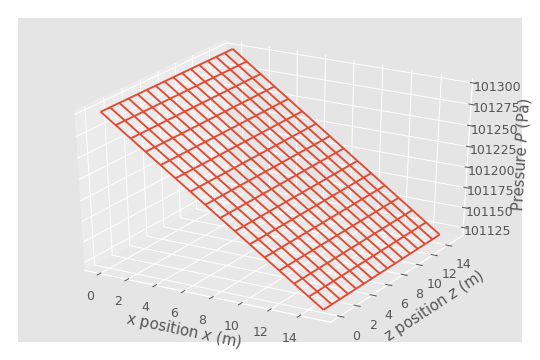

In [206]:
ax0 = plot_y(pt[0,:,10,:])

<IPython.core.display.Javascript object>


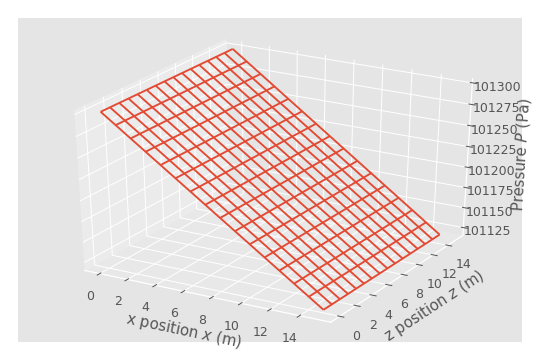

In [208]:
ax1 = plot_y(pt[1,:,10,:])

<IPython.core.display.Javascript object>


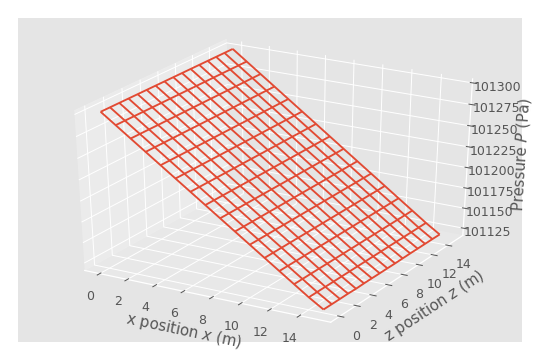

In [207]:
ax10 = plot_y(pt[19,:,10,:])